In [88]:
import xsimlab as xs
import xarray as xr
import numpy as np

In [89]:
!pip freeze | grep xarray-simlab

-e git+https://github.com/benbovy/xarray-simlab.git@5ac494a65b2e1cc08baf506cd70b69843f8eb1a7#egg=xarray_simlab


This demo uses `xarray-simlab` v0.4.1 (`5ac494a65b2e1cc08baf506cd70b69843f8eb1a7`).

# 20201112_xsimlab_demo

The purpose of this notebook is to provide a brief interactive tutorial to the [`xarray-simlab`](https://xarray-simlab.readthedocs.io/en/latest/)(or `xsimlab`) package, which is used extensively throughout the [`episimlab`](https://github.com/eho-tacc/episimlab) package.

For the most up-to-date documentation on `episimlab`'s dependencies, the reader is referred to the following sources:
* [`episimlab` GitHub](https://github.com/eho-tacc/episimlab)
* [`xarray-simlab` Read the Docs](https://xarray-simlab.readthedocs.io/en/latest/)
* [`xarray-simlab` GitHub](https://github.com/benbovy/xarray-simlab)
* [`xarray` Read the Docs](http://xarray.pydata.org/)

----

From the official docs:

> xarray-simlab is a Python library that provides both a generic framework for building computational models in a modular fashion and a xarray extension for setting and running simulations using the xarray.Dataset structure. It is designed for fast, interactive and exploratory modeling.

In `xsimlab`, "building ... models in a modular fashion" occurs when the user combines a unique set of modular components (known as `process`es in the API) into an aggregate `model`. Processes are lightweight Python classes with definitions for specific input and output variables of that process (just like a function!). We define a `process` by wrapping a Python class using the `xsimlab.process` decorator:

In [90]:
@xs.process
class AnExampleProcess:
    example_input_var = xs.variable(intent='in')
    example_output_var = xs.variable(intent='out')
    
    def initialize(self):
        print('in AnExampleProcess initialize phase')
        # must define the instance attribute
        self.example_output_var = 0
        
    def run_step(self):
        print('in AnExampleProcess run_step phase')
    
    def finalize_step(self):
        print('in AnExampleProcess finalize_step phase')
        self.example_output_var += self.example_input_var
    
    def finalize(self):
        print('in AnExampleProcess finalize phase')

#### About this Definition

* The process defines an expected input variable (denoted by `intent='in'`) and an expected output variable (denoted by `intent='out'`)
    * These variables are **class** attributes, so we still must define the instance attribute of the output variable `example_output_var` in `initialize`
* `xsimlab` recognizes four particular class methods, which are listed above in chronological order
    * `initialize` runs before the simulation starts
    * `run_step` runs once for every step of the simulation (usually a time step)
    * `finalize_step` runs once after every `run_step`
    * `finalize` runs after the simulation is done iterating
    
----

We could make a (very basic and very boring) model from just this one process, but let's make a more interesting model by adding another process. We will make this other process do one thing: set the value of `example_input_var` based on some other variable `upstream_input_var`:

In [91]:
@xs.process
class SetInputVar:
    upstream_input_var = xs.variable(static=True, intent='in')
    example_input_var = xs.foreign(AnExampleProcess, 'example_input_var', intent='out')
    
    def initialize(self):
        print('in SetInputVar initialize phase')
        self.example_input_var = -self.upstream_input_var

In this second process, we use `xs.foreign` instead of `xs.variable` to define `example_input_var` as an existing variable in the model. Specifically, we want the model to know that the `example_input_var` in `SetInputVar` is the same as the variable in `AnExampleProcess`.

Also, note the addition of the `static` kwarg, which will "freeze" `upsteam_input_var` to one value throughout the simulation, kind of like a tuple vs list.

## Build the Model from Processes

With **two** processes, we can make a slightly more interesting model. Remember that to define a `model`, we simply list a set of processes that we want to string together:

In [92]:
boring_model = xs.Model({
    'set_input': SetInputVar,
    'do_something': AnExampleProcess
})

## Inspect the Model

`xsimlab` provides a nice set of tools for inspection of our model. We get nice representations when we print out the model instance or one of the processes:

In [93]:
boring_model

<xsimlab.Model (2 processes, 1 inputs)>
set_input
    upstream_input_var     [in]
do_something

...but also for processes and variables:

In [94]:
boring_model.do_something

<AnExampleProcess 'do_something' (xsimlab process)>
Variables:
    example_input_var      [in]
    example_output_var    [out]
Simulation stages:
    initialize
    run_step
    finalize_step
    finalize

We also get some nice model visualization tools:

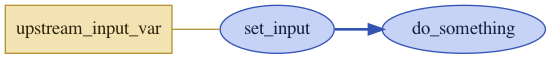

In [95]:
boring_model.visualize(show_variables=False, show_inputs=True)

We see that we will need to supply `upstream_input_var` as an input to the model, and that it will be used by the upstream process `set_input`. We can also look at how the variables are handled throughout the model:

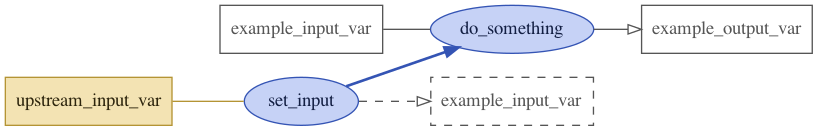

In [96]:
boring_model.visualize(show_variables=True, show_inputs=True)

## Run the Model

We have confirmed that our model looks right (`SetInputVar` is upstream), so let's run the model. To run the model, we aggregate input variables and other parameters into an input `xarray.Dataset`, which is very similar to a `pandas.DataFrame`:

In [97]:
input_dataset = xs.create_setup(
    model=boring_model,
    # define the time axis, determines how many steps
    # there are in the simulation
    clocks={
        'step': range(5)
    },
    # define our input variable here
    # note the syntax <process name>__<variable name> separated by double underscore
    input_vars={
        'set_input__upstream_input_var': -2
    },
    # define which variables we want to see in the output data
    output_vars={
        'do_something__example_output_var': 'step'
    }
)
input_dataset

<xarray.Dataset>
Dimensions:                        (step: 5)
Coordinates:
  * step                           (step) int64 0 1 2 3 4
Data variables:
    set_input__upstream_input_var  int64 -2

Our boring model has a very minimal input dataset, with one input value that is a constant integer value along the chronological `step` axis. In the required `clock` kwarg, we say that we want to run this model for 3 time steps.

Let's run this model:

In [98]:
output_dataset = input_dataset.xsimlab.run(model=boring_model)

in SetInputVar initialize phase
in AnExampleProcess initialize phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess finalize phase


As expected, we see that `initialize` runs first, then `run_step` and `finalize_step` iterate a few times, then `finalize`. Let's look at the output variable in the output Dataset:

In [99]:
output_dataset

<xarray.Dataset>
Dimensions:                           (step: 5)
Coordinates:
  * step                              (step) int64 0 1 2 3 4
Data variables:
    do_something__example_output_var  (step) int64 0 2 4 6 8
    set_input__upstream_input_var     int64 -2

## Save / Analyze Output

The output of the simulation is an [`xarray.Dataset`](http://xarray.pydata.org/en/latest/generated/xarray.Dataset.html), so we can save, load, and manipulate it using the xarray and Dask APIs:

In [100]:
print(type(output_dataset))

<class 'xarray.core.dataset.Dataset'>


For instance, we can save the output to a NetCDF:

In [101]:
output_dataset.to_netcdf('./20201112_demo_output.nc')
!ls ./20201112_demo_output.nc

./20201112_demo_output.nc


...or plot the `example_output_var` as it progresses through the simulation along the `step` axis:

<class 'xarray.core.dataarray.DataArray'>


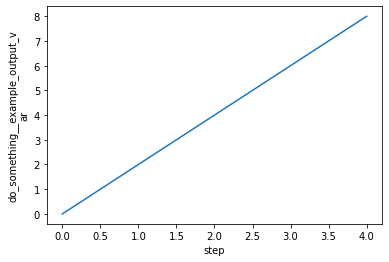

In [102]:
example_output_var = output_dataset['do_something__example_output_var']
print(type(example_output_var))
example_output_var.plot()

Note that the above operations are supported for `input_dataset` because it is also an `xarray.Dataset`.

## Modify Existing Models

Great! We have successfully built and run our first basic model. However, our model is currently very simple, and as curious scientists, we now want to expand its capabilities. Thanks to the modular design of `xsimlab` models, it is quite easy to extend and scale existing models to more complex ones (like the ones provided in `episimlab`).

It should come as no surprise that we will be extending the model by adding/modifying processes. Let us say that we want to tweak the behavior of `AnExampleProcess`. We could scroll up and change the original process, or we could keep it unchanged, and replace it with a new process that inherits from it. The latter option is better for reusability and reproducibility, and its pretty easy:

In [103]:
@xs.process
class ExampleChildProcess(AnExampleProcess):
    example_coord = xs.index(dims=('example_coord'))
    example_output_var = xs.variable(dims=('example_coord'), intent='out')
    
    def initialize(self):
        print('in ExampleChildProcess initialize phase')
        self.example_output_var = np.array([5, 4, 3])
        self.example_coord = range(3)

#### A Brief Description of Python Inheritance

By "subclassing" or "inheriting" the `AnExampleProcess` class defined previously, we provide a starting point for our `ExampleChildProcess` definition. All the class attributes (variables like `example_input_var`, and methods like `run_step` and `finalize_step`) are inherited. To implement modified behavior, we replace certain class attributes, such as the `initialize` method or the `example_output_var` variable, with new definitions that effectively overwrite the definitions inherited from `AnExampleProcess`. For a more complete and formal description of Python inheritance, I would recommend one of the many helpful guides that can be found via Google.

#### Okay, but what is this process doing?

Besides some very basic changes to the `initialize` and `finalize` steps (200 vs 100 and 1 vs 0), we have added dimensionality to the `example_output_var` variable. Specifically, we have added a dimension called `example_coord` (`dims=('example_coord')`), with a coordinate set `example_coord` defined as an `xsimlab.index`.

To add this new process to our model, we could build it from scratch using the `xsimlab.Model` constructor. It is more convenient to use the `Model.update_processes` method, however:

In [104]:
swanky_model = boring_model.update_processes({
    'do_something': ExampleChildProcess
})
swanky_model

<xsimlab.Model (2 processes, 1 inputs)>
set_input
    upstream_input_var     [in]
do_something

In [105]:
swanky_model.do_something

<ExampleChildProcess 'do_something' (xsimlab process)>
Variables:
    example_input_var      [in]
    example_coord         [out] ('example_coord',) 
    example_output_var    [out] ('example_coord',) 
Simulation stages:
    initialize
    run_step
    finalize_step
    finalize

We see that the 'do_something' process has been successfully replaced with the modified process. We run the model as before:

In [106]:
# set up input dataset
swanky_in_ds = xs.create_setup(
    model=swanky_model,
    clocks={
        'step': range(5)
    },
    input_vars={
        'set_input__upstream_input_var': -2
    },
    output_vars={
        'do_something__example_output_var': 'step'
    }
)

# run the model
swanky_out_ds = swanky_in_ds.xsimlab.run(model=swanky_model)
swanky_out_ds

in SetInputVar initialize phase
in ExampleChildProcess initialize phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess finalize phase


<xarray.Dataset>
Dimensions:                           (example_coord: 3, step: 5)
Coordinates:
  * example_coord                     (example_coord) int64 0 1 2
  * step                              (step) int64 0 1 2 3 4
Data variables:
    do_something__example_output_var  (step, example_coord) int64 5 4 ... 12 11
    set_input__upstream_input_var     int64 -2

We see that adding the `example_coord` dimension generates the expected 2-D shape (with `step` and `example_coord` dims) in the output, with the expected values.

Let's add one more process. We want `example_input_var` to equal zero for certain steps of the simulation. There are a couple ways to do this:

In [107]:
@xs.process
class OneWay(SetInputVar):
    zero_interval = xs.variable(dims=('value'), static=True, intent='in')
    
    @xs.runtime(args=['step'])
    def run_step(self, step):
        assert isinstance(step, int)
        assert len(self.zero_interval) == 2
        
        if self.zero_interval[0] <= step <= self.zero_interval[1]:
            self.example_input_var = 0
        else:
            self.example_input_var = -self.upstream_input_var

In this process, we use the [`xsimlab.runtime` decorator](https://xarray-simlab.readthedocs.io/en/latest/_api_generated/xsimlab.runtime.html#xsimlab.runtime) so that the `run_step` method can track the integer `step` number throughout the simulation. In short, we can get very complex model behavior with just a few lines of code!

Remember: because we are subclassing `SetInputVar`, we inherit the class definitions for `upstream_input_var`, `example_input_var`, and `initialize`, so we do not need to redefine these in `OneWay`.

As usual, let's add this process to our model, inspect it, and run it.

In [108]:
fancy_model = swanky_model.update_processes({'set_input': OneWay})

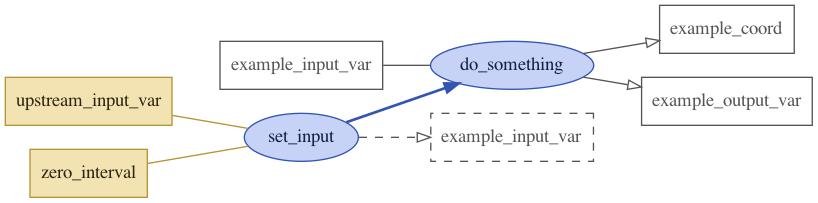

In [109]:
fancy_model.visualize(show_variables=True)

In [110]:
fancy_model.set_input

<OneWay 'set_input' (xsimlab process)>
Variables:
    upstream_input_var     [in]
    example_input_var     [out] ---> do_something.example_input_var
    zero_interval          [in] ('value',) 
Simulation stages:
    initialize
    run_step

In [111]:
# set up input dataset
fancy_in_ds = xs.create_setup(
    model=fancy_model,
    clocks={
        'step': range(5)
    },
    input_vars={
        'set_input__upstream_input_var': -2,
        'set_input__zero_interval': [1, 2]
    },
    output_vars={
        'do_something__example_output_var': 'step',
        # we want to make sure that example_input_var
        # is behaving as expected
        'do_something__example_input_var': 'step'
    }
)

# run the model
fancy_out_ds = fancy_in_ds.xsimlab.run(model=fancy_model)
fancy_out_ds

in SetInputVar initialize phase
in ExampleChildProcess initialize phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess finalize phase


<xarray.Dataset>
Dimensions:                           (example_coord: 3, step: 5, value: 2)
Coordinates:
  * example_coord                     (example_coord) int64 0 1 2
  * step                              (step) int64 0 1 2 3 4
Dimensions without coordinates: value
Data variables:
    do_something__example_input_var   (step) int64 2 0 0 2 2
    do_something__example_output_var  (step, example_coord) int64 5 4 3 ... 8 7
    set_input__upstream_input_var     int64 -2
    set_input__zero_interval          (value) int64 1 2

Note that we included `example_input_vars` in the `output_vars` dictionary, which allows us to check that `OneWay` is behaving as expected.

### The other way

What if we want to calculate `example_input_var` outside of the `xsimlab` framework? Maybe it's values are contained in a file (actually, a process would still be good for this purpose), or we don't want to do pre-processing in `xsimlab` for one reason or another. We can simply remove the `set_input` process from the model, which will now expect `example_input_var` as an input passed to the **model**:

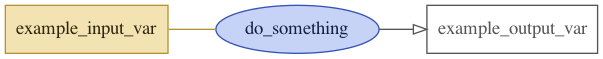

In [112]:
no_setup_model = boring_model.drop_processes(['set_input'])
no_setup_model.visualize(show_variables=True)

Our (once again) boring model can now be run, and we can explicitly pass pre-calculated `example_input_var` as a model input:

In [113]:
# set up input dataset
no_setup_in_ds = xs.create_setup(
    model=no_setup_model,
    clocks={
        'step': range(5)
    },
    input_vars={
        # note that we must pass a DataArray here
        # so that the model knows that the represented
        # dimension is `step`
        'do_something__example_input_var': xr.DataArray([2, 0, 0, 2, 2], dims=['step']),
    },
    output_vars={
        'do_something__example_output_var': 'step'
    }
)

# run the model
no_setup_out_ds = no_setup_in_ds.xsimlab.run(model=no_setup_model)
no_setup_out_ds

in AnExampleProcess initialize phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess run_step phase
in AnExampleProcess finalize_step phase
in AnExampleProcess finalize phase


<xarray.Dataset>
Dimensions:                           (step: 5)
Coordinates:
  * step                              (step) int64 0 1 2 3 4
Data variables:
    do_something__example_input_var   (step) int64 2 0 0 2 2
    do_something__example_output_var  (step) int64 0 2 2 2 4